Running Cantera version: 2.6.0


/tmp/ipykernel_13884/1731707490.py:21: DeprecationWarning: XML_Node::build: 
The CTI and XML input file formats are deprecated and will be removed in
Cantera 3.0. Use 'cti2yaml.py' or 'ctml2yaml.py' to convert CTI or XML input
files to the YAML format. See https://cantera.org/tutorials/legacy2yaml.html
for more information.
  gas = ct.Solution('data/dmf.cti')


Computed Ignition Delay Time: 7.528e-04 seconds.
Took 0.37 seconds to compute


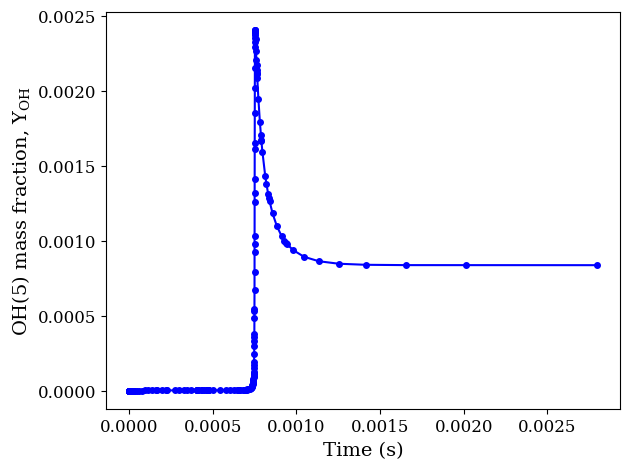

In [1]:
# Simulate ignition delay time (IDT) in a Shock Tube reactor.

# conda create --name ct-env --channel cantera cantera ipython matplotlib jupyter
# conda activate ct-env

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import time
print('Running Cantera version: ' + ct.__version__)


# -----------------
# User input:

temperature = 1310  # Kelvin

pressure = 3.92 * 101325.0  # Convert bar to Pascals (the final units here must be Pascal)

# Load the model:
gas = ct.Solution('data/dmf.cti')

# Define the components and concentrations. The names must match to thoes in your model:
gas.X = {'DMF(1)': 0.01, 'O2(2)': 0.075, 'Ar': 0.915}

# Estimate the ignition delay time, this is used to tell the algorithm how long to keep searching for the IDT:
estimatedIgnitionDelayTime = 0.005

# Give the percise name from the model of the species used to compute the IDT (usually, this is OH)
idt_species = 'OH(5)'

# Give a name for the output figure. Define as None to supress saving the figure:
figure_name = 'IDT_1.jpg'

# End of user input
# -----------------




# This function computes the ignition delay time (IDT)
# from the occurrence of the peak concentration for the specified species (usually OH).
def ignitionDelay(states, species):
    i_ign = states(species).Y.argmax()
    return states.t[i_ign]

# Set the thermodynamic state of the gas object:
gas.TP = temperature, pressure

# Create a reactor object and add it to a "reactor network"
# In this example, this will be the only reactor in the network
r = ct.Reactor(contents=gas)
reactorNetwork = ct.ReactorNet([r])

# Create a timeHistory object to keep track of chemical time
timeHistory = ct.SolutionArray(gas, extra=['t'])

# Tic (measure walltime to know how much time the simulation took to execute)
t0 = time.time()

t = 0
counter = 1
while t < estimatedIgnitionDelayTime:
    t = reactorNetwork.step()
    if counter % 20 == 0:
        # We will save only every 20th value. Otherwise, this takes too long
        # Note that the species concentrations are expressed as **mass** fractions
        timeHistory.append(r.thermo.state, t=t)
    counter += 1

# The species that is used to compute the ignition delay
tau = ignitionDelay(timeHistory, idt_species)

# Toc (end point for walltime)
t1 = time.time()
print(f"Computed Ignition Delay Time: {tau:.3e} seconds.\nTook {t1-t0:3.2f} seconds to compute")


# Plot the result
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['font.family'] = 'serif'
plt.figure()
plt.plot(timeHistory.t, timeHistory(idt_species).Y, '-o', color='b', markersize=4)
plt.xlabel('Time (s)')
plt.ylabel(f'{idt_species} mass fraction, ' + r'$\mathdefault{Y_{OH}}$')

# Figure formatting:
# plt.xlim([0, 0.00055])
# plt.ylim([0, 0.000055])
# ax.annotate("", xy=(tau, 0.005), xytext=(0, 0.005),
#             arrowprops=dict(arrowstyle="<|-|>", color='k', linewidth=2.0),
#             fontsize=14)
# plt.annotate('Ignition Delay Time (IDT)', xy=(0, 0), xytext=(0.00008, 0.00525),
#              fontsize=16)

if figure_name:
    plt.savefig(figure_name, dpi=300, format='jpg')

ax = plt.gca()
plt.show()
